## Predicting skin cancer from a dataset in Kaggle:Skin Cancer MNIST: HAM10000.
#### More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (followup), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesionid-column within the HAM10000_metadata file.

#### Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

### Import necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
from xgboost import XGBClassifier

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### Import the data

In [2]:
df = pd.read_csv('skin_lesions.csv')

In [3]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### In the data description, there was a statement about the lesions having multiple images, so some of the lesion_ids have multiple image_ids for the same lesion. I grouped the data by lesion_id to confirm that

In [4]:
df.groupby(['lesion_id'], as_index = False).count().head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000000,2,2,2,2,2,2
1,HAM_0000001,1,1,1,1,1,1
2,HAM_0000002,3,3,3,3,3,3
3,HAM_0000003,1,1,1,1,1,1
4,HAM_0000004,1,1,1,1,1,1
5,HAM_0000005,4,4,4,4,4,4
6,HAM_0000006,3,3,3,3,3,3
7,HAM_0000007,1,1,1,1,1,1
8,HAM_0000008,1,1,1,1,1,1
9,HAM_0000009,3,3,3,3,3,3


### I set the dataframe to reveal all of its rows, so I can see all the rows when I grouped the data by diagnosis (dx) and localization in the subsequent cell

In [5]:
pd.set_option('display.max_rows', None)
df = pd.read_csv("skin_lesions.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
df.groupby(['dx', 'localization']).count()
# I wanted to see if the diagnosis had any specific areas of the body it was prone to...


lesion_id  image_id  dx_type   age   sex
dx    localization                                             
akiec abdomen                  5         5        5     5     5
      back                    29        29       29    29    29
      chest                   12        12       12    12    12
      ear                      3         3        3     3     3
      face                   113       113      113   113   113
      hand                    13        13       13    13    13
      lower extremity         65        65       65    65    65
      neck                    10        10       10    10    10
      scalp                   14        14       14    14    14
      trunk                    1         1        1     1     1
      upper extremity         62        62       62    62    62
bcc   abdomen                 18        18       18    18    18
      back                   186       186      186   186   186
      chest                   47        47       47    47    47
      face                   101       101      101   101   101
      foot                     4         4        4     4     4
      hand                     2         2        2     2     2
      lower extremity         58        58       58    58    58
      neck                    14        14       14    14    14
      scalp                   19        19       19    19    19
      trunk                   11        11       11    11    11
      unknown                  5         5        5     5     5
      upper extremity         49        49       49    49    49
bkl   abdomen                 42        42       42    42    42
      back                   202       202      202   202   202
      chest                   74        74       74    74    74
      ear                      6         6        6     6     6
      face                   319       319      319   319   319
      foot                     1         1        1     1     1
      genital                  2         2        2     2     2
      hand                    14        14       14    14    14
      lower extremity        174       174      174   174   174
      neck                    31        31       31    31    31
      scalp                   34        34       34    34    34
      trunk                   73        73       73    73    73
      unknown                 23        23       23    13    23
      upper extremity        104       104      104   104   104
df    abdomen                  4         4        4     4     4
      back                     2         2        2     2     2
      foot                     2         2        2     2     2
      genital                  1         1        1     1     1
      lower extremity         82        82       82    82    82
      upper extremity         24        24       24    24    24
mel   abdomen                 66        66       66    66    66
      back                   324       324      324   324   324
      chest                   68        68       68    68    68
      ear                     17        17       17    17    17
      face                   104       104      104   102   104
      foot                    28        28       28    28    28
      hand                     1         1        1     1     1
      lower extremity        192       192      192   192   192
      neck                    29        29       29    29    29
      scalp                   14        14       14    14    14
      trunk                   47        47       47    47    47
      unknown                 10        10       10    10    10
      upper extremity        213       213      213   213   213
nv    abdomen                860       860      860   859   860
      acral                    7         7        7     7     7
      back                  1427      1427     1427  1427  1427
      chest                  200       200      200   198   200
      ear                     30        30       30    

### Get the null information in each column

In [7]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

### Replaced the NaN's in the 'Age' column with the average age 

In [8]:
df.age.replace(np.nan, df.age.mean(), inplace = True)

### Confirm NAN has been replaced

In [9]:
df.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

### Investigating the data to see what's in it. 
#### I first start with observing the abundance of the skin lesions (dx) in descending order and then the other columns, as well.

In [10]:
df.dx.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [11]:
df.dx_type.value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [12]:
df.localization.value_counts()

back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64

In [13]:
df.sex.value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [14]:
df.age.value_counts().head()

45.0    1299
50.0    1187
55.0    1009
40.0     985
60.0     803
Name: age, dtype: int64

### Replace the 'unknown' values in the 'sex' column with the mode, which is the male values of 0,; and assign both male and female to integer values

In [15]:
df.sex.replace('unknown', 0, inplace = True)
df.sex.replace('male', 0, inplace = True)
df.sex.replace('female', 1, inplace = True)

### Replace the other string objects in the different columns with integers

In [16]:
df.dx_type.replace('histo', 3, inplace = True)
df.dx_type.replace('follow_up', 2, inplace = True)
df.dx_type.replace('consensus', 1, inplace = True)
df.dx_type.replace('confocal', 0, inplace = True)

In [17]:
df.localization.replace('back', 14, inplace = True)
df.localization.replace('lower extremity', 13, inplace = True)
df.localization.replace('trunk', 12, inplace = True)
df.localization.replace('upper extremity', 11, inplace = True)
df.localization.replace('abdomen', 10, inplace = True)
df.localization.replace('face', 9, inplace = True)
df.localization.replace('chest', 8, inplace = True)
df.localization.replace('foot', 7, inplace = True)
df.localization.replace('unknown', 6, inplace = True)
df.localization.replace('neck', 5, inplace = True)
df.localization.replace('scalp', 4, inplace = True)
df.localization.replace('hand', 3, inplace = True)
df.localization.replace('ear', 2, inplace = True)
df.localization.replace('genital', 1, inplace = True)
df.localization.replace('acral', 0, inplace = True)
 

In [18]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,3,80.0,0,4
1,HAM_0000118,ISIC_0025030,bkl,3,80.0,0,4
2,HAM_0002730,ISIC_0026769,bkl,3,80.0,0,4
3,HAM_0002730,ISIC_0025661,bkl,3,80.0,0,4
4,HAM_0001466,ISIC_0031633,bkl,3,75.0,0,2


### Since the same 'lesion_id's have multiple 'image_id's I'll include them in the assessment, by taking out the string and 0's.  

In [19]:
lesion_id = label_encoder.fit_transform(df['lesion_id'])
lesion_id = pd.DataFrame({'lesion_id': lesion_id})

In [20]:
df.lesion_id = lesion_id

In [21]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,118,ISIC_0027419,bkl,3,80.0,0,4
1,118,ISIC_0025030,bkl,3,80.0,0,4
2,2710,ISIC_0026769,bkl,3,80.0,0,4
3,2710,ISIC_0025661,bkl,3,80.0,0,4
4,1460,ISIC_0031633,bkl,3,75.0,0,2


### Because the image_id is distinct for each row, it serves as an unnecessary part of the dataframe, so I'll drop it later

## Data Visualization

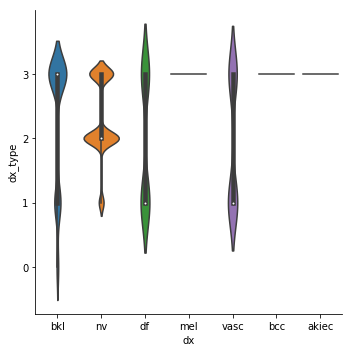

In [22]:
sns.catplot('dx', 'dx_type', kind = 'violin', data = df)
# mel, bcc, akiec have only one diagnosis type: histology, shown as 3 and confirmed in the next cell below
# vasc and df have two diagnosis types: histology and consensus
# both nv and blk were diagnosed three ways


#below is a dictionary for the various dx
#{'nv': 'melanocytic nevi'}
#{'mel': 'melanoma'}
#{'bkl': 'keratoses'}
#{'bcc': 'basal cell carcinoma'}
#{'akiec': "Bowen's disease"}
#{'vasc':'vascular lesions'}
#{'df': 'dermatofibroma'}

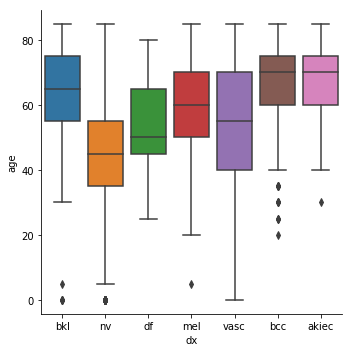

In [23]:
sns.catplot('dx', 'age', kind = 'box', data = df)

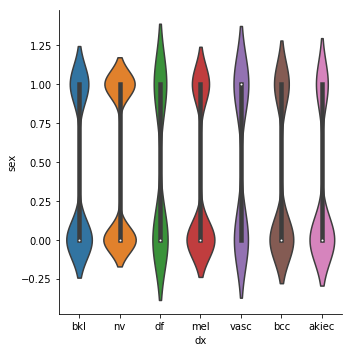

In [24]:
sns.catplot('dx','sex', kind = 'violin', data = df)

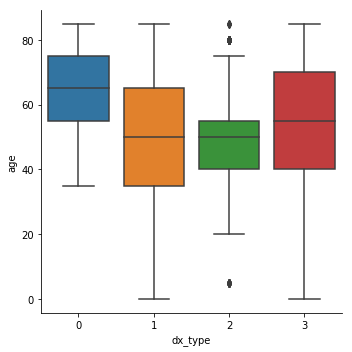

In [25]:
sns.catplot('dx_type', 'age', kind = 'box', data = df)
# confocal microscopy happens at an older age. Histology is next.

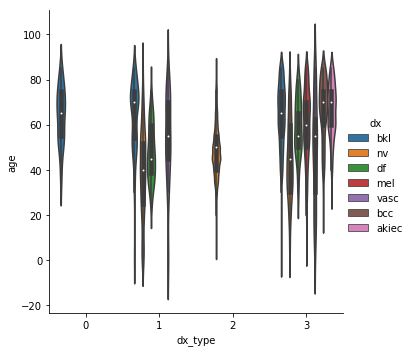

In [26]:
sns.catplot('dx_type', 'age', kind = 'violin', data = df, hue = 'dx')
#It looks like for every type of diagnosis histology is the best. 
#Follow-up diagnosis doesn't look too productive, but it's useful for nv
#Consensus also does a good job at diagnosing, but not a thorough job as histology
#blk looks to only be diagnosable by confocal microscopy

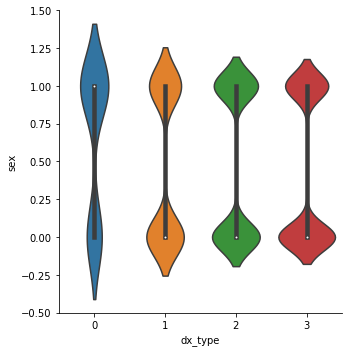

In [27]:
sns.catplot('dx_type', 'sex', kind = 'violin', data = df)
#In general, it looks like the men have more diagnosis done than women, expect for confocal microscopy,
# which in the case of men makes sense because there's more of them in the data. But the fact that women have more microscopy dx_type
#means more of them have blk than men. There may be more to the story of why women have more blackheads than men in this data.

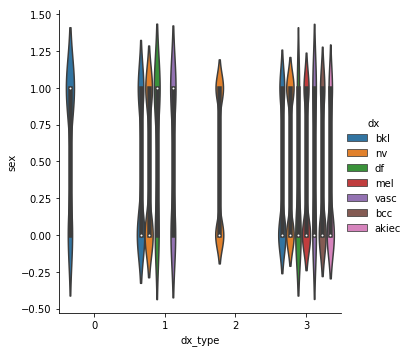

In [28]:
sns.catplot('dx_type', 'sex', kind = 'violin', data = df, hue = 'dx')
#Again, here it looks like for every type of diagnosis histology is the best. Follow-up doesn't look too productive, but it's useful for nv
#Consensus also does a good job at diagnosing, but not a thorough job as histology
#blk looks to only be diagnosable by confocal microscopy

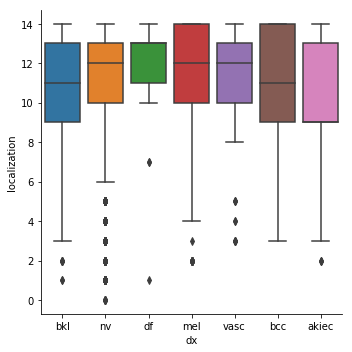

In [29]:
sns.catplot('dx','localization', kind = 'box', data = df)

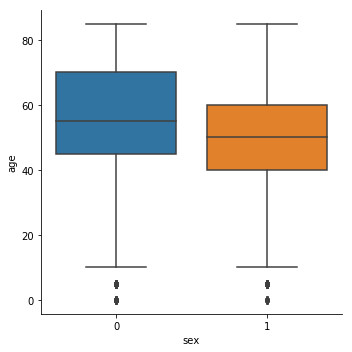

In [30]:
sns.catplot('sex','age', kind = 'box', data = df)
# The men are diagnosed at an older age than women

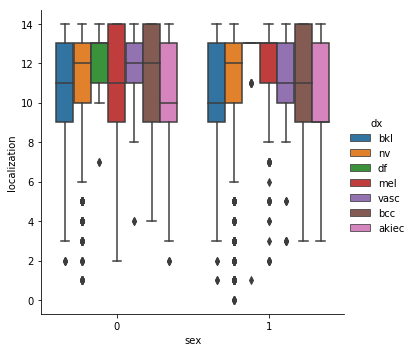

In [31]:
sns.catplot('sex','localization', kind = 'box', data = df, hue = 'dx')

#This shows diagnosis is different between the two sexes

In [32]:
df.dx.replace('nv', 'melanocytic nevi', inplace = True)
df.dx.replace('mel', 'melanoma', inplace = True)
df.dx.replace('bkl', 'keratoses', inplace = True)
df.dx.replace('bcc', 'basal cell carcinoma', inplace = True)
df.dx.replace('akiec', "Bowen's disease", inplace = True)
df.dx.replace('vasc', 'vascular lesions ', inplace = True)
df.dx.replace('df', 'dermatofibroma', inplace = True)

## Now I drop the 'image_id'

In [33]:
df.drop(['image_id'], axis = 1, inplace = True)

In [34]:
df.head()

,lesion_id,dx,dx_type,age,sex,localization
0,118,keratoses,3,80.0,0,4
1,118,keratoses,3,80.0,0,4
2,2710,keratoses,3,80.0,0,4
3,2710,keratoses,3,80.0,0,4
4,1460,keratoses,3,75.0,0,2


### I need to rearrange the dataframe to be able to have dx at the end, so I can create an x and y dataframe

In [35]:
ld = df.drop(['dx', 'dx_type', 'age', 'sex', 'localization'], axis = 1)

In [36]:
ld.head()

,lesion_id
0,118
1,118
2,2710
3,2710
4,1460


In [37]:
sd = df.drop(['lesion_id'], axis = 1)

In [38]:
sd.head()

,dx,dx_type,age,sex,localization
0,keratoses,3,80.0,0,4
1,keratoses,3,80.0,0,4
2,keratoses,3,80.0,0,4
3,keratoses,3,80.0,0,4
4,keratoses,3,75.0,0,2


In [39]:
result = pd.concat([sd, ld], axis=1)

### Now that dx is in an optimal location I split the dataframe into x and y

In [40]:
result.head()

,dx,dx_type,age,sex,localization,lesion_id
0,keratoses,3,80.0,0,4,118
1,keratoses,3,80.0,0,4,118
2,keratoses,3,80.0,0,4,2710
3,keratoses,3,80.0,0,4,2710
4,keratoses,3,75.0,0,2,1460


In [41]:
x = result.iloc[:,1:]

In [42]:
x.head()

,dx_type,age,sex,localization,lesion_id
0,3,80.0,0,4,118
1,3,80.0,0,4,118
2,3,80.0,0,4,2710
3,3,80.0,0,4,2710
4,3,75.0,0,2,1460


In [43]:
y = result.iloc[:,0:1]

In [44]:
y.head()

,dx
0,keratoses
1,keratoses
2,keratoses
3,keratoses
4,keratoses


## Import necessary liabraries to begin training the model

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

### Get the train and test data sets

In [46]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.15, random_state = 42)

In [47]:
dt = DecisionTreeClassifier(random_state = 42)
gr = GradientBoostingRegressor()
gc = GradientBoostingClassifier(learning_rate = 0.5)
rf = RandomForestClassifier()
ss = StandardScaler()
sv = SVC()
sl = SVC(C = 0.1, kernel = 'linear')
sp = SVC(C = 0.1, kernel = 'poly')
xg = XGBClassifier(learning_rate = 0.999)
knn = KNeighborsClassifier()
nb = GaussianNB()

### Trying out different models to see which one fits best

In [48]:
#K Nearest Neighbor
knn.fit(xtrain, ytrain)
knn.score(xtrain, ytrain)
knn.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.6373918829008649

In [49]:
nb.fit(xtrain, ytrain) # Naive Bayes
nb.score(xtrain, ytrain)
nb.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5948103792415169

In [50]:
dt.fit(xtrain, ytrain) # Decision Trees
dt.score(xtrain, ytrain)
dt.score(xtest, ytest)

0.8609447771124418

In [51]:
rf.fit(xtrain, ytrain) # Random Forest
rf.score(xtrain, ytrain)
rf.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


0.8709248170326015

### I standardize the data and then used Random Forest in a pipeline, which gave me a lower accuracy score than using Random Forest alone, which wasn't what I expected

In [52]:
pipe = Pipeline([('ss', ss), ('rf', rf)])

In [53]:
pipe.fit(xtrain, ytrain)
pipe.score(xtrain, ytrain)
pipe.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


0.872255489021956

In [54]:
#sv.fit(xtrain, ytrain)
#sv.score(xtrain, ytrain)
#sv.score(xtest, ytest)

In [55]:
#sl.fit(xtrain, ytrain)
#sl.score(xtrain, ytrain)
#sl.score(xtest, ytest)

In [56]:
#sp.fit(xtrain, ytrain)
#sp.score(xtrain, ytrain)
#sp.score(xtest, ytest)

## Boosting
### I then tried different boosting methods to see which one works better.

In [57]:
gc.fit(xtrain, ytrain) # Gradient Boosting Classifier
gc.score(xtrain, ytrain)
gc.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.7791084497671324

In [58]:
xg.fit(xtrain, ytrain) #XGBoosting
xg.score(xtrain, ytrain)
xg.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.874251497005988

## Stacking a few models
### I stacked two algorithms as an alternative to try to improve the accuracy score

In [59]:
model = ([('gc', gc), ('xg', xg)]) # Gradient Boosting Classifier and XGBoosting
stacking = StackingClassifier(estimators = model)
stacking.fit(xtrain, ytrain)
stacking.score(xtrain, ytrain)
stacking.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

0.8762475049900199

In [60]:
model = ([('dt', dt), ('xg', xg)]) # Decision Tree and XGBoosting
stacking = StackingClassifier(estimators = model)
stacking.fit(xtrain, ytrain)
stacking.score(xtrain, ytrain)
stacking.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

0.8749168330006654

In [61]:
model = ([('rf', rf), ('xg', xg)]) # Random Forest and XGBoosting
stacking = StackingClassifier(estimators = model)
stacking.fit(xtrain, ytrain)
stacking.score(xtrain, ytrain)
stacking.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

0.8789088489687292

In [62]:
model = ([('knn', knn), ('dt', dt)]) # KNN and Decision Trees
stacking = StackingClassifier(estimators = model)
stacking.fit(xtrain, ytrain)
stacking.score(xtrain, ytrain)
stacking.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

0.8629407850964738

In [63]:
model = ([('nb', nb), ('xg', xg)]) # Naive Bayes and XGBoosting
stacking = StackingClassifier(estimators = model)
stacking.fit(xtrain, ytrain)
stacking.score(xtrain, ytrain)
stacking.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

0.8762475049900199

In [64]:
model = ([('nb', nb), ('rf', rf)]) # Naive Bayes and Random Forest
stacking = StackingClassifier(estimators = model)
stacking.fit(xtrain, ytrain)
stacking.score(xtrain, ytrain)
stacking.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

0.8715901530272788

In [65]:
model = ([('knn', knn), ('xg', xg)]) # KNN and XGBoosting
stacking = StackingClassifier(estimators = model)
stacking.fit(xtrain, ytrain)
stacking.score(xtrain, ytrain)
stacking.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

0.8755821689953427

In [66]:
model = ([('dt', dt), ('gc', gc)]) # Decision Trees and Gradient Boosting Classifier
stacking = StackingClassifier(estimators = model)
stacking.fit(xtrain, ytrain)
stacking.score(xtrain, ytrain)
stacking.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

0.8602794411177644

In [67]:
model = ([('dt', dt), ('nb', nb)]) ## Decision Trees and Naive Bayes
stacking = StackingClassifier(estimators = model)
stacking.fit(xtrain, ytrain)
stacking.score(xtrain, ytrain)
stacking.score(xtest, ytest)

C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\emf-a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

0.8589487691284099

## Please feel free to work on it to get the accuracy score into the 90% range. I'm not sure what I'm doing wrong